In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import math
from scipy.ndimage.filters import gaussian_filter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Constants and functions

In [3]:
G=6.67408*1e-11
# [m**3]
def volume_sphere(r):
    return 4./3*math.pi*r**3
# delta_density [g/cm**3] -> mass [kg]
def delta_mass_sphere(r, delta_density):
    return 1000.*delta_density*volume_sphere(r)
# [мГал]
def delta_grav(delta_mass, x,y,z):
    return (100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5)

def raster_gamma_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

## Synthetic Density Model

In [4]:
L = 500
Z = 100
x = np.linspace(-L,L,2*L+1)
z = -np.arange(1,Z+1)
(xx,zz) = np.meshgrid(x,z)

da_density = xr.DataArray(np.zeros(zz.shape), coords={'z': z, 'x': x}, dims=['z','x'])
# add some additive noise if needed
#da_density.values = np.random.rand(len(z),len(x))-0.5

In [5]:
def gaussian(x, z, std, amplitude):
    r2 = x**2 + z**2
    return amplitude*np.exp(-r2/std**2)

X0 = [350,375,400,450,500,550,600,625,650]
Z0 = [50,0,50,25,0+50,25,50,0,50]
V0 = [-1,-1,1,-1,-1,-1,1,-1,-1]
for (x0, z0, v0) in zip(X0,Z0,V0):
    da_density.values += gaussian(xx+x0-L, zz+z0, 40, v0)

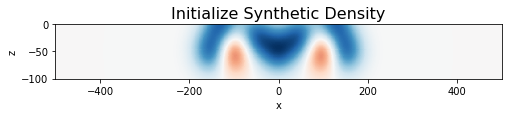

In [6]:
da_density.plot(figsize=(8, 1), add_colorbar=False)
plt.title('Initialize Synthetic Density', fontsize=16)
plt.show()

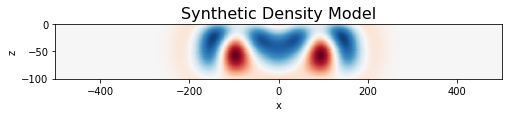

In [7]:
da_fdensity = raster_gamma_range(da_density, 20,21)
da_fdensity.plot(figsize=(8, 1), add_colorbar=False)
plt.title('Synthetic Density Model', fontsize=16)
plt.show()

## Gravity Forward Model

In [8]:
def _delta_grav(val, dx, dz):
    return delta_grav(delta_mass_sphere(.5,val), dx, 0, -dz)
da_gravity = xr.apply_ufunc(_delta_grav, da_fdensity, x-da_fdensity.x, da_fdensity.z).sel(z=0, method='nearest')

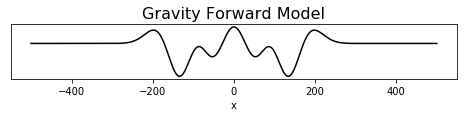

In [9]:
# change threshold above if plot is not smooth
fig = plt.figure(figsize=(8,1))
ax1 = fig.add_subplot(1, 1, 1)
da_gravity.plot(ax=ax1, c='black')
plt.title('Gravity Forward Model', fontsize=16)
plt.gca().get_yaxis().set_ticks([])
plt.show()

## Circular Hough Transform [Focal Average]

In [10]:
rs = np.arange(150)
means = []
for r in rs:
    mask = np.concatenate([[1],np.zeros(2*r-1),[1]]) if r>0 else [1]
    mean = np.convolve(da_gravity, mask/np.sum(mask), mode='same')
    means.append(mean)
means = np.array(means)

dx = da_gravity.x.diff('x').values[0]
da_gravity_focal = xr.DataArray(means, coords=[-dx*rs/np.sqrt(2),x], dims=['z','x'])

## Plot the models

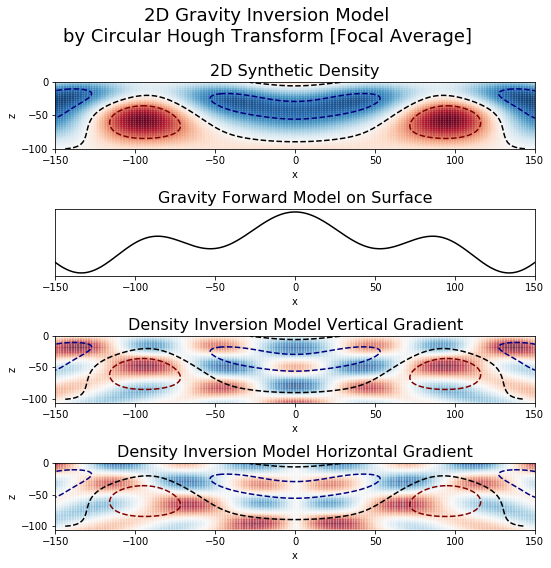

In [11]:
xsize = 150
levels=[-2e-2,0,1.5e-2]
colors=['navy','black','maroon']

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(4, 1, 1)
da_fdensity.plot(ax=ax, alpha=0.5, add_colorbar=False)
da_fdensity.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('2D Synthetic Density', fontsize=16)
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 1, 2)
da_gravity.plot(ax=ax, c='black')
ax.set_title('Gravity Forward Model on Surface', fontsize=16)
ax.get_yaxis().set_ticks([])
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 1, 3)
# vertical gradient
grd = da_gravity_focal.diff('z')
grd.plot(ax=ax, alpha=0.2,  add_colorbar=False)
da_fdensity.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Vertical Gradient', fontsize=16)
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 1, 4)
# radial gradient (from x gradient)
grd = da_gravity_focal.diff('x')
grd.values[:,:500] = -grd.values[:,:500]
grd.plot(ax=ax, alpha=0.2, add_colorbar=False)
da_fdensity.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model Horizontal Gradient', fontsize=16)
ax.set_xlim([-xsize, xsize])

plt.suptitle('2D Gravity Inversion Model\nby Circular Hough Transform [Focal Average]', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('2D Synthetic Density Inversion by Circular Hough Transform [Focal Average].jpg', quality=95)
plt.show()